In [19]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from string import ascii_uppercase
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, multilabel_confusion_matrix
import keras
import cv2
from tensorflow.keras.utils import img_to_array
import imutils
import os
import warnings 
warnings.filterwarnings('ignore')


In [2]:
#Loading Data
df_train = pd.read_csv('sign_mnist_train.csv')
df_test = pd.read_csv('sign_mnist_test.csv')
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
# Checking NaNs
print('NaNs in training set ',sum(df_train.isna().sum() >1)) 
print('NaNs in testing set ',sum(df_test.isna().sum() >1))


NaNs in training set  0
NaNs in testing set  0


In [4]:
# Checking Null
print('Null in training set ',sum(df_train.isnull().sum() >1)) 
print('Null in testing set ',sum(df_test.isnull().sum() >1))


Null in training set  0
Null in testing set  0


In [5]:
LETTERS = {letter: index for  letter,index in enumerate(ascii_uppercase, start=0)}


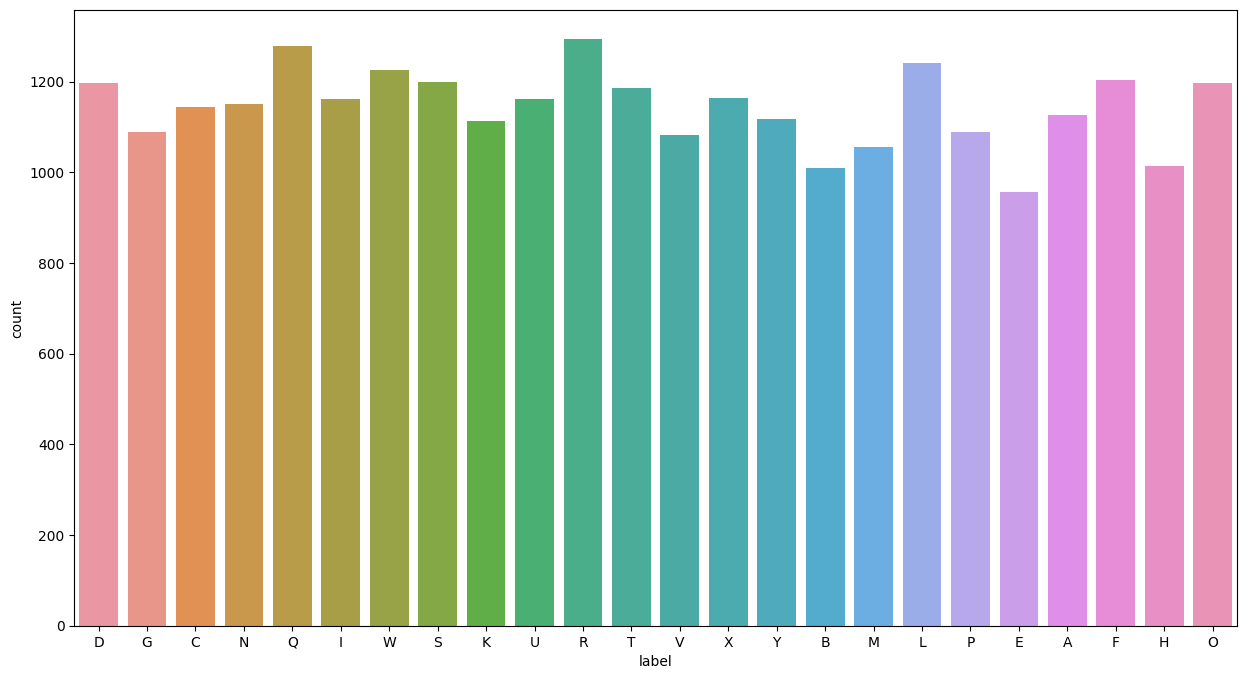

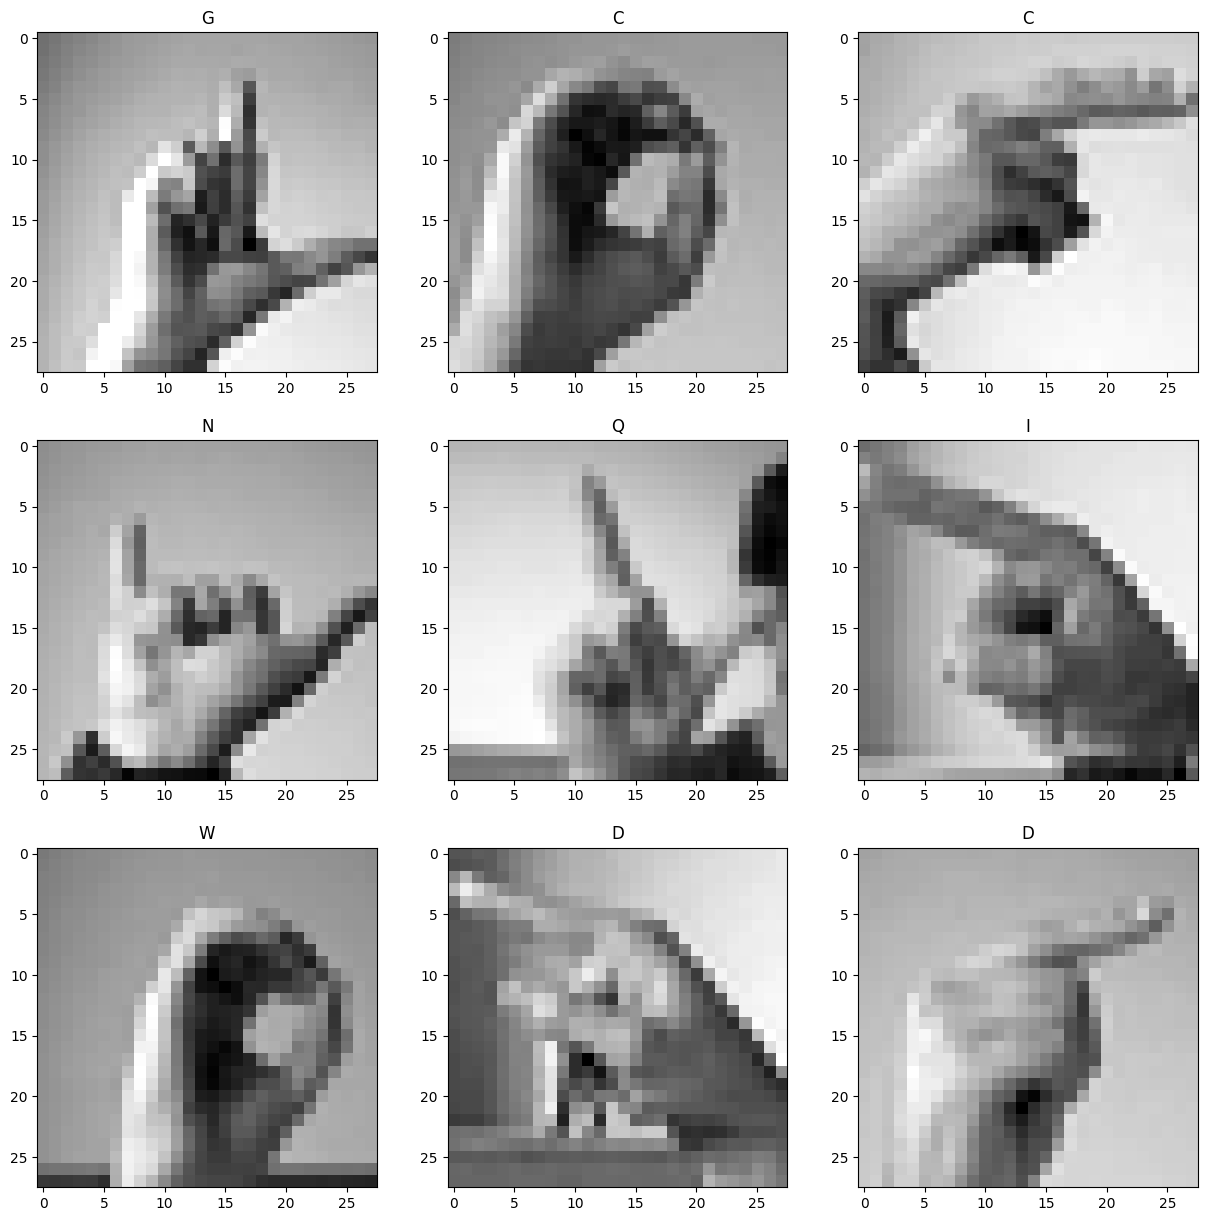

In [6]:
#Visualizing Train Data
df1 = df_train
df1=df1.replace({"label": LETTERS})
plt.figure(figsize=(15,8))
sns.countplot(x = df1['label'])
plt.show()

j = 1
plt.figure(figsize=(15,15))
for i in np.random.randint(0, len(df1), size=(9,)):
    plt.subplot(3,3,j)
    plt.imshow(df1.iloc[i,1:].to_numpy().reshape(28,28).astype(int),cmap='gray')
    plt.title(df1.iloc[j,0])
    j+=1
plt.show()

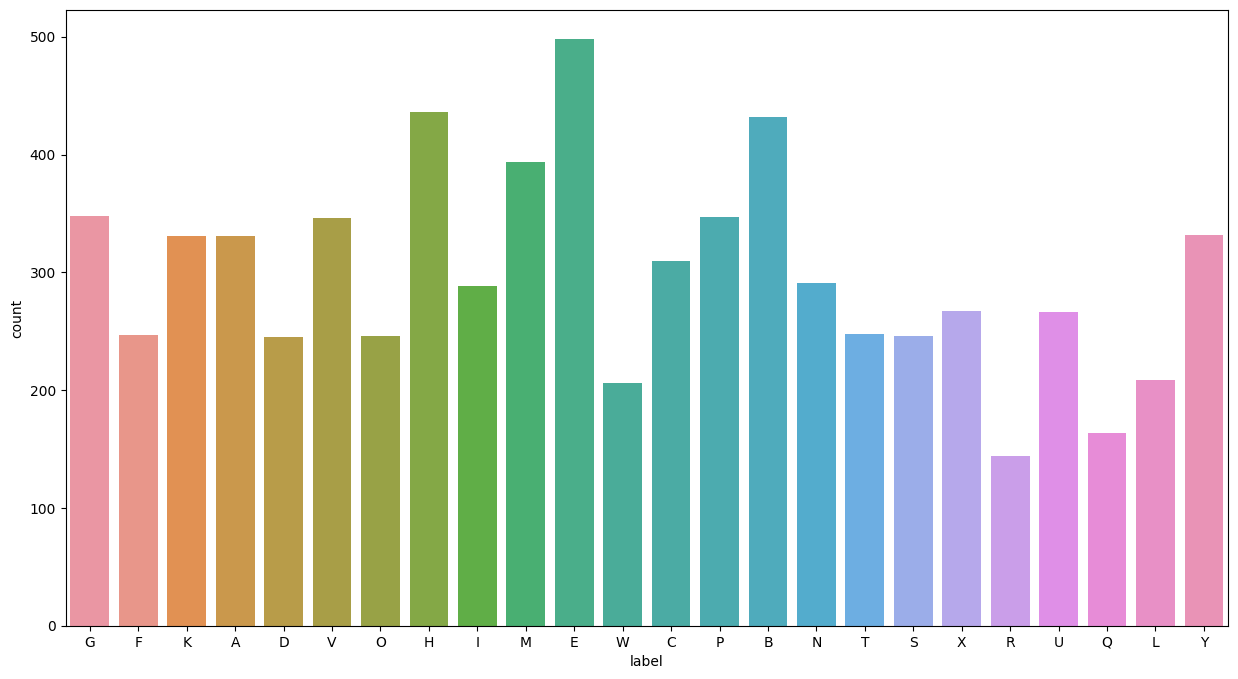

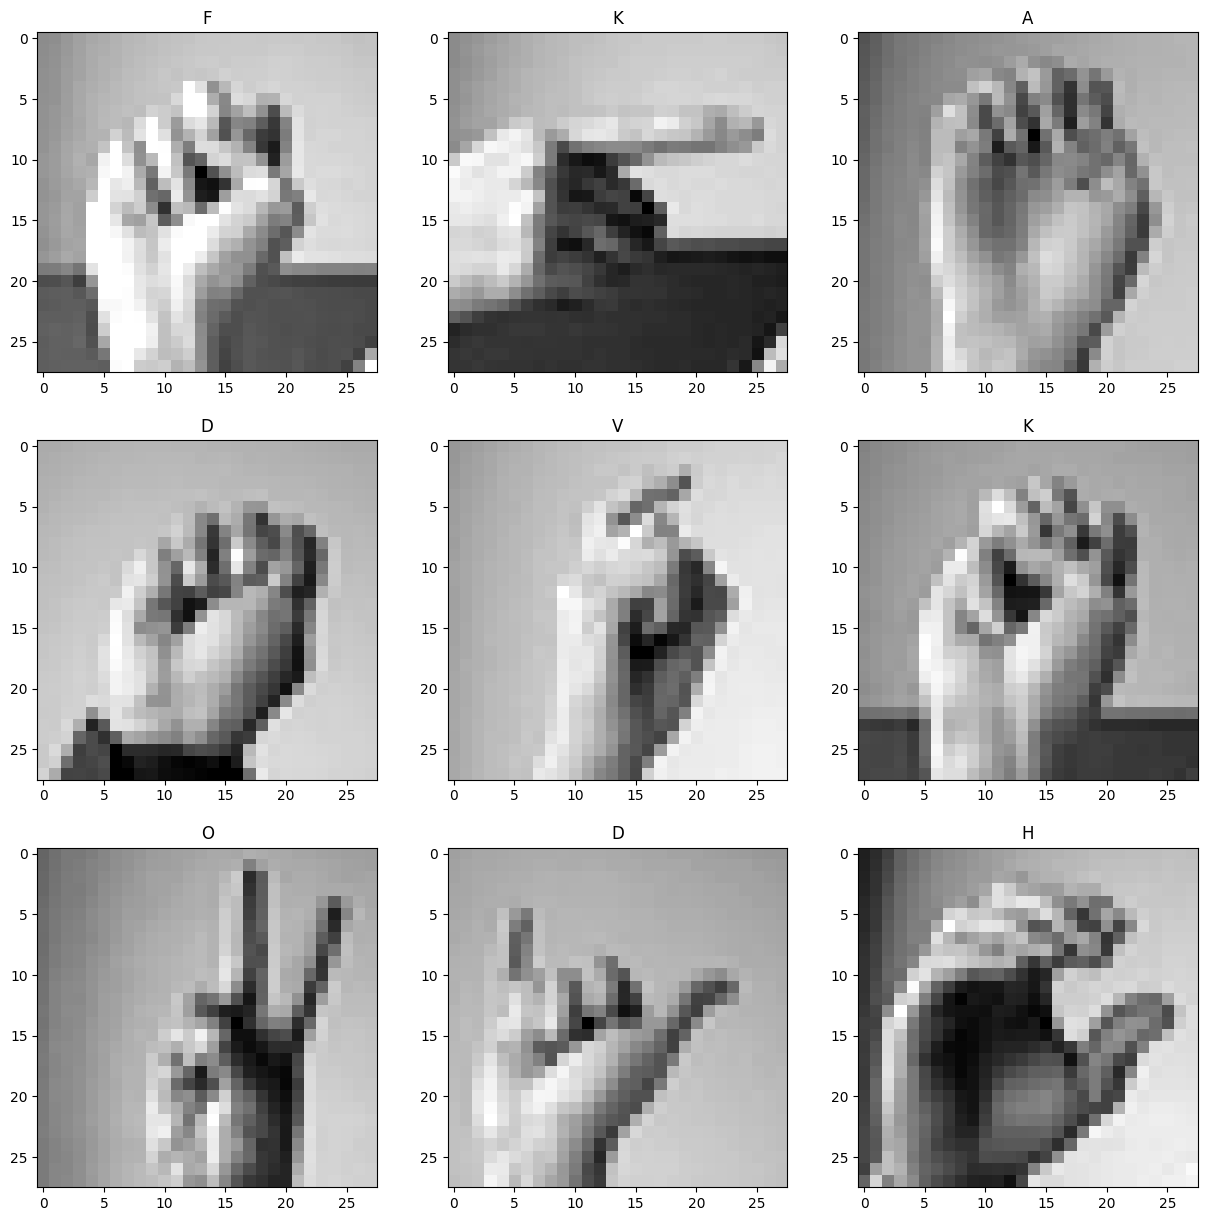

In [7]:
#Visualizing Testing Data
df2 = df_test
df2=df2.replace({"label": LETTERS})
plt.figure(figsize=(15,8))
sns.countplot(x = df2['label'])
plt.show()

j = 1
plt.figure(figsize=(15,15))
for i in np.random.randint(0, len(df2), size=(9,)):
    plt.subplot(3,3,j)
    plt.imshow(df2.iloc[i,1:].to_numpy().reshape(28,28).astype(int),cmap='gray')
    plt.title(df2.iloc[j,0])
    j+=1
plt.show()

In [8]:
X_train = df_train.drop(columns = 'label',axis = 1)
y_train = df_train['label']

X_test = df_test.drop(columns = 'label',axis=1)
y_test = df_test['label']



In [9]:
# Reshaping 
X_train = X_train.values.reshape(X_train.shape[0],*(28,28,1))
X_test = X_test.values.reshape(X_test.shape[0],*(28,28,1))

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [10]:
# Image Augmentation
train_generator = ImageDataGenerator(rescale = 1./255,
                                     zoom_range = 0.2,
                                     width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     shear_range = 0.1,
                                     rotation_range = 20,
                                     horizontal_flip = True,
                                     vertical_flip = False)

test_generator = ImageDataGenerator(rescale = 1./255)

Train_Aug = train_generator.flow(X_train, y_train,batch_size = 32)
Test_Aug = test_generator.flow(X_test,y_test,batch_size=32)

In [11]:
# Model

model = Sequential()

model.add(Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))


model.add(Conv2D(filters=64,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))


model.add(Conv2D(filters=128,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=24, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer='adam',  metrics=["accuracy"])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [13]:
callbacks = EarlyStopping(
                   monitor='val_loss',
                   patience=5,
                   restore_best_weights=True
                   )

In [14]:
history = model.fit(Train_Aug, validation_data=Test_Aug,epochs=50, callbacks=callbacks)

Epoch 1/50
858/858 [==============================] - 13s 15ms/step - loss: 2.5327 - accuracy: 0.2066 - val_loss: 1.2582 - val_accuracy: 0.5929
Epoch 2/50
858/858 [==============================] - 13s 15ms/step - loss: 1.3585 - accuracy: 0.5380 - val_loss: 0.7072 - val_accuracy: 0.7391
Epoch 3/50
858/858 [==============================] - 14s 16ms/step - loss: 0.9342 - accuracy: 0.6730 - val_loss: 0.4568 - val_accuracy: 0.8218
Epoch 4/50
858/858 [==============================] - 13s 15ms/step - loss: 0.7204 - accuracy: 0.7477 - val_loss: 0.3292 - val_accuracy: 0.8905
Epoch 5/50
858/858 [==============================] - 13s 15ms/step - loss: 0.6137 - accuracy: 0.7858 - val_loss: 0.2514 - val_accuracy: 0.9283
Epoch 6/50
858/858 [==============================] - 13s 15ms/step - loss: 0.5127 - accuracy: 0.8234 - val_loss: 0.1729 - val_accuracy: 0.9518
Epoch 7/50
858/858 [==============================] - 13s 16ms/step - loss: 0.4593 - accuracy: 0.8394 - val_loss: 0.1529 - val_accuracy:

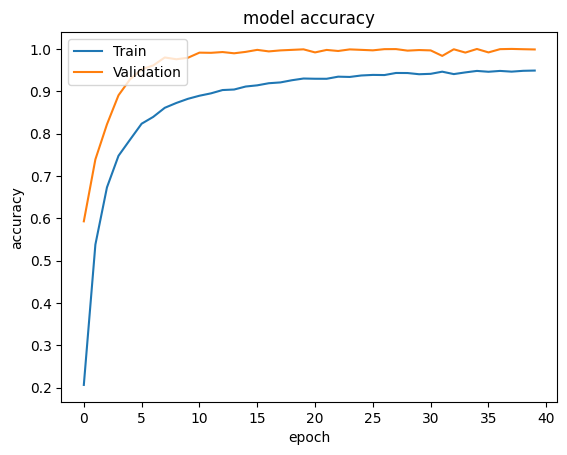

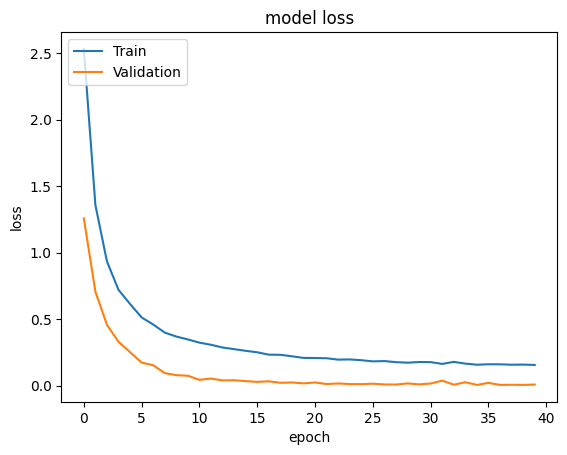

In [16]:
# Visualizing 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
model.save('sign_language')

INFO:tensorflow:Assets written to: sign_language\assets


INFO:tensorflow:Assets written to: sign_language\assets


### Webcam Implementation

In [20]:
alphabet=['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y'] #Does not contain J and Z

In [21]:
#Classification of images
def classify(image):
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    proba=model.predict(image)
    idx = np.argmax(proba)
    return alphabet[idx]

In [ ]:
# Testing on Webcam
cap = cv2.VideoCapture(0)
while 1:
    ret, img = cap.read()
    image = cv2.imread('amer_sign2.png')
    cv2.imshow("image", image)
    img = cv2.flip(img, 1)
    top, right, bottom, left = 75, 350, 300, 590
    roi = img[top:bottom, right:left]
    roi=cv2.flip(roi,1)
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    cv2.imshow('roi',gray)
    alpha=classify(gray)
    cv2.rectangle(img, (left, top), (right, bottom), (0,255,0), 2)
    font=cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,alpha,(0,130),font,5,(0,0,255),2)
    #cv2.resize(img,(1000,1000))
    cv2.imshow('img',img)
    key = cv2.waitKey(1) & 0xFF
    if key==ord('j'):
        break;
cap.release()
cv2.destroyAllWindows()